# GOLEM Fast Spectrometry Analysis

This notebook demonstrates analysis of GOLEM tokamak diagnostic data using the `golem_data_loader` module.

## Features of the data loader:
- **Type-safe**: Full type annotations for better IDE support
- **Robust error handling**: Automatic retries with configurable delays
- **Flexible**: Load all or specific spectroscopy lines
- **Well-documented**: Comprehensive docstrings and examples
- **Easy to use**: Simple API with sensible defaults

In [44]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter, freqz
from scipy import fft

# Import the GOLEM data loader module
from golem_data_loader import GolemDataLoader, SpectroscopyLine

# Increase global font sizes for readability
plt.rcParams.update(
    {
        "font.size": 12,  # base font size
        "axes.labelsize": 18,  # x/y labels
        "axes.titlesize": 18,  # subplot titles
        "xtick.labelsize": 14,  # x tick labels
        "ytick.labelsize": 14,  # y tick labels
        "legend.fontsize": 14,  # legends
        "figure.titlesize": 16,  # suptitle
    }
)

shotno = 50377

## Load Data from GOLEM Web Server

Using the `golem_data_loader` module to fetch diagnostic data with automatic retry logic and error handling.

In [45]:
# Initialize the GOLEM data loader
loader = GolemDataLoader(shotno)

# Load fast spectrometry data
spectrometry_data = loader.load_fast_spectrometry()

# Convert to the original data format for backward compatibility
data = {name: spec_data.raw_dataframe for name, spec_data in spectrometry_data.items()}

# Print loaded data info
for label, spec_data in spectrometry_data.items():
    print(f"{label}: loaded {len(spec_data.time)} rows")

2025-11-11 21:47:21,820 - golem_data_loader - INFO - Successfully loaded Hα spectrometry from http://golem.fjfi.cvut.cz/shots/50377/Diagnostics/FastSpectrometry/U_Halpha.csv
2025-11-11 21:47:21,843 - golem_data_loader - INFO - Hα: loaded 3999 rows, columns = ['    0', '0.003']
2025-11-11 21:47:21,843 - golem_data_loader - INFO - Hα: loaded 3999 rows, columns = ['    0', '0.003']
2025-11-11 21:47:21,872 - golem_data_loader - INFO - Successfully loaded Hβ spectrometry from http://golem.fjfi.cvut.cz/shots/50377/Diagnostics/FastSpectrometry/U_Hbeta.csv
2025-11-11 21:47:21,874 - golem_data_loader - INFO - Hβ: loaded 3999 rows, columns = ['    0', '0.003']
2025-11-11 21:47:21,872 - golem_data_loader - INFO - Successfully loaded Hβ spectrometry from http://golem.fjfi.cvut.cz/shots/50377/Diagnostics/FastSpectrometry/U_Hbeta.csv
2025-11-11 21:47:21,874 - golem_data_loader - INFO - Hβ: loaded 3999 rows, columns = ['    0', '0.003']
2025-11-11 21:47:21,935 - golem_data_loader - INFO - Successfull

Hα: loaded 3999 rows
Hβ: loaded 3999 rows
He I: loaded 3999 rows
Whole: loaded 3999 rows


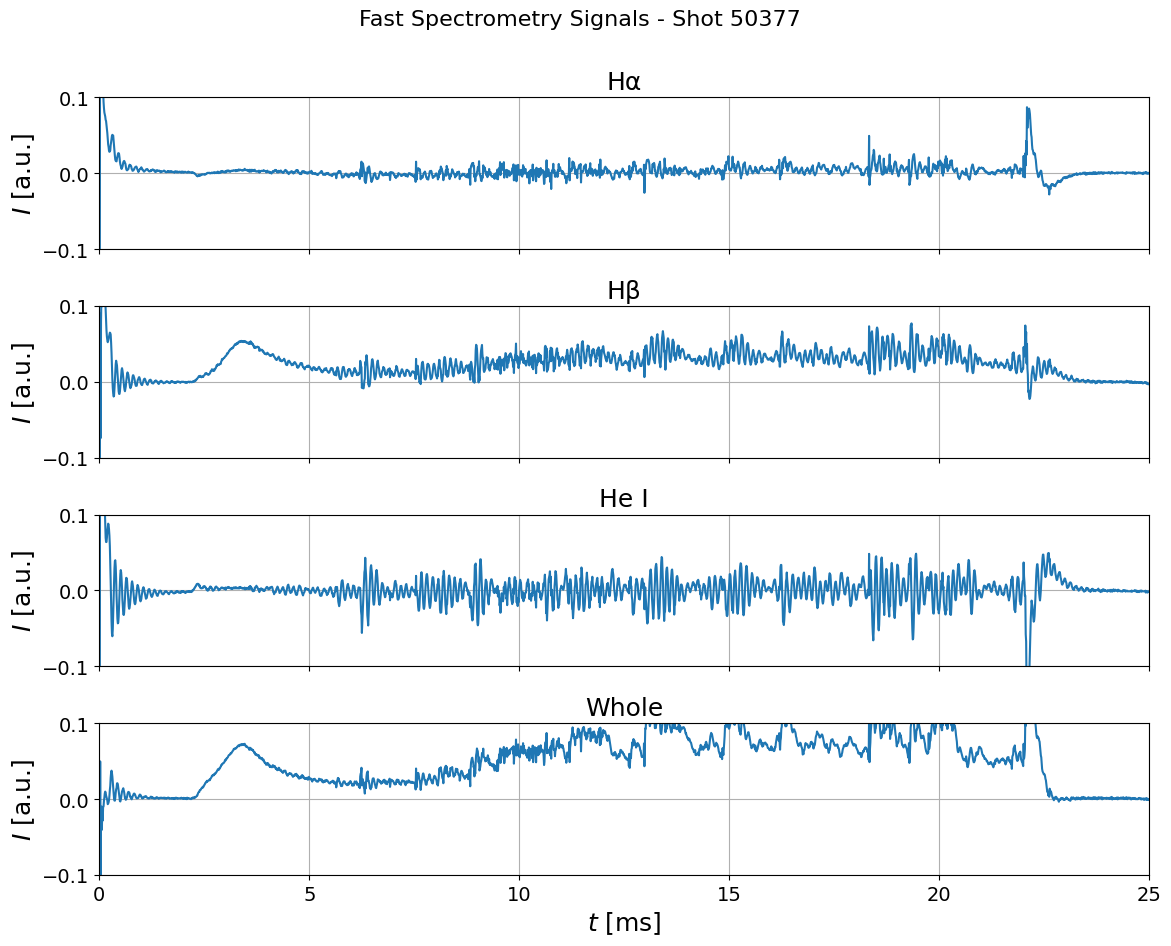

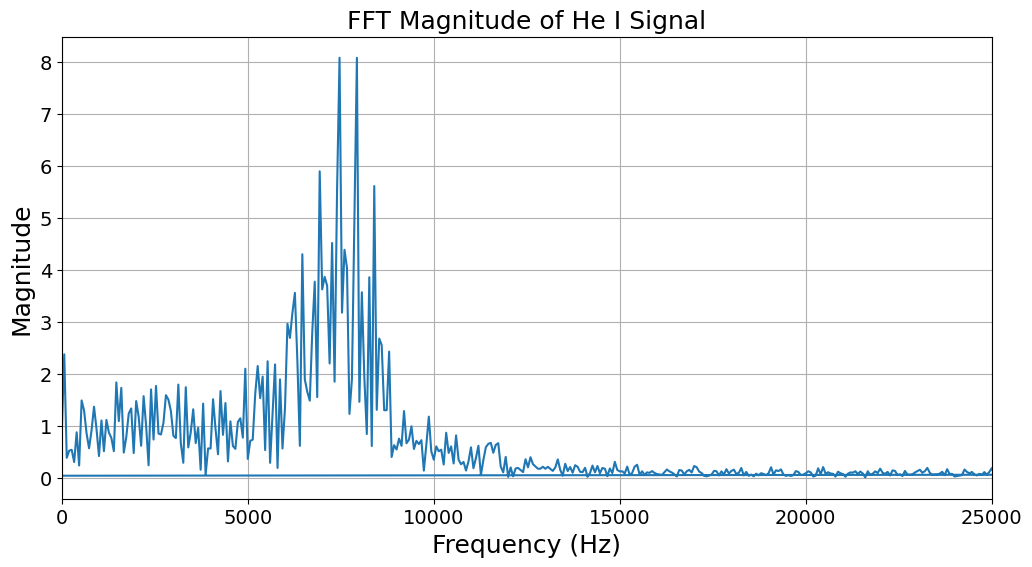

In [46]:
# One figure, four stacked subplots (share X for alignment)
fig, axes = plt.subplots(nrows=4, sharex=True, figsize=(12, 10), sharey=True)

noise_coeff = 0.4
noise = np.array(data["He I"].iloc[:, 1])
noise = np.roll(noise, -1)  # Shift noise data for better comparison

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter(order, cutoff, fs=fs, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

for ax, (label, df) in zip(axes, data.items()):
    t = df.iloc[:, 0] * 1e3  # convert to ms
    u = df.iloc[:, 1]
    ax.plot(t, u - noise*noise_coeff, label=label)
    # ax.plot(t, butter_lowpass_filter(u, 1000, 100e3), label=label)
    # ax.plot(t, u, color="gray", alpha=0.5, label="Noise (Whole)", marker=".")
    ax.set_ylabel(r"$I$ [a.u.]")
    ax.grid(True)
    ax.set_title(label)
    ax.set_xlim(0, 25)
    ax.set_ylim(-0.1, 0.1)
    # ax.set_yscale('log')

# Label only the bottom axis with X label
# Use LaTeX-style mathtext for x-axis label
axes[-1].set_xlabel(r"$t$ [ms]")

# Figure-level title (fontsize controlled by rcParams figure.titlesize)
# Move it slightly closer to the subplots
fig.suptitle(f"Fast Spectrometry Signals - Shot {shotno}", y=0.975)

# Adjust layout; raise the top of the axes area to sit closer to the suptitle
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

# Show the single figure with all four subplots
plt.show()

# Compute FFT for He I signal
he_i_signal = data["He I"].iloc[:, 1].values[500:2000]
# he_i_signal = np.sin(0.01*np.pi*np.arange(len(he_i_signal)))  # Example signal
fft_he_i = fft.fft(he_i_signal)
freqs = fft.fftfreq(len(he_i_signal), d=1e-5)

# plt.plot()

# Plot the magnitude of the FFT
plt.figure(figsize=(12, 6))
plt.plot(freqs, np.abs(fft_he_i))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0,25000)
plt.title('FFT Magnitude of He I Signal')
plt.grid(True)
plt.show()

In [47]:
# Load mini-spectrometer H5 data using the loader module
h5_data = loader.load_minispectrometer_h5()

# Extract spectra and wavelengths
Spectra = h5_data.spectra
Wavelengths = h5_data.wavelengths

print(f"Loaded spectra with shape: {Spectra.shape}")
print(f"Wavelength range: {Wavelengths[0]:.2f} - {Wavelengths[-1]:.2f} nm")

2025-11-11 21:47:22,525 - golem_data_loader - INFO - Downloading H5 file to /var/folders/8r/sqs2hl_s6f3fmch121kzp_yh0000gn/T/tmpk9ldh59_.h5
2025-11-11 21:47:22,612 - golem_data_loader - INFO - Successfully loaded mini-spectrometer H5 file from http://golem.fjfi.cvut.cz/shots/50377/Diagnostics/MiniSpectrometer/DAS_raw_data_dir/IRVISUV_0.h5
2025-11-11 21:47:22,613 - golem_data_loader - INFO - Successfully downloaded H5 file (102864 bytes)
2025-11-11 21:47:22,621 - golem_data_loader - INFO - Loaded spectra: shape=(20, 2048), wavelengths: shape=(2047,)
2025-11-11 21:47:22,622 - golem_data_loader - INFO - Cleaned up temporary file: /var/folders/8r/sqs2hl_s6f3fmch121kzp_yh0000gn/T/tmpk9ldh59_.h5
2025-11-11 21:47:22,612 - golem_data_loader - INFO - Successfully loaded mini-spectrometer H5 file from http://golem.fjfi.cvut.cz/shots/50377/Diagnostics/MiniSpectrometer/DAS_raw_data_dir/IRVISUV_0.h5
2025-11-11 21:47:22,613 - golem_data_loader - INFO - Successfully downloaded H5 file (102864 bytes)


Loaded spectra with shape: (20, 2048)
Wavelength range: 188.11 - 1108.53 nm


In [48]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def compare_spectrometer(peaks, Wavelengths, Spectra):
    # Create a 2x2 grid of axes and flatten for sequential indexing
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(12, 10), sharey=True)
    axes_flat = axes.flatten()

    for n, peak in enumerate(peaks):
        # Select wavelengths within +/- (FWHM/2) around the peak wavelength
        wavelength_mask = (Wavelengths >= peak["wavelength"] - peak["fwhm"]/2) & (Wavelengths <= peak["wavelength"] + peak["fwhm"]/2)
        wavelength_indexes = np.where(wavelength_mask)[0]

        # Create time array and integrate intensity for each spectrum
        mini_spectrometer_t = np.arange(2, 2*len(Spectra)+2, 2)
        mini_spectrometer_intensity = []

        for i in range(len(Spectra)):
            # Extract intensity values at the selected wavelength indexes
            spectrum_slice = Spectra[i][wavelength_indexes]
            # Integrate using trapezoidal rule
            total_intensity = np.trapz(spectrum_slice, Wavelengths[wavelength_indexes])
            mini_spectrometer_intensity.append(total_intensity)

        mini_spectrometer_intensity = np.array(mini_spectrometer_intensity)

        # Plot mini spectrometer integrated intensity over time on the corresponding axis
        ax = axes_flat[n]
        ax.plot(mini_spectrometer_t, normalize(mini_spectrometer_intensity))

        # Add gray plot of Hβ signal passed through butter_lowpass_filter
        t_hb = peak["fs_data"].iloc[:, 0][500:] * 1e3  # convert to ms
        u_hb = peak["fs_data"].iloc[:, 1][500:]
        filtered_hb = butter_lowpass_filter(u_hb, 1000, 100e3)
        ax.plot(t_hb, normalize(filtered_hb), color='gray', label='Hβ Filtered')

        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Integrated Intensity (a.u.)')
        ax.set_title(f"{peak['name']} at {peak['wavelength']} nm")

        ax.grid(True)
        ax.legend()

    fig.tight_layout()
    plt.show()

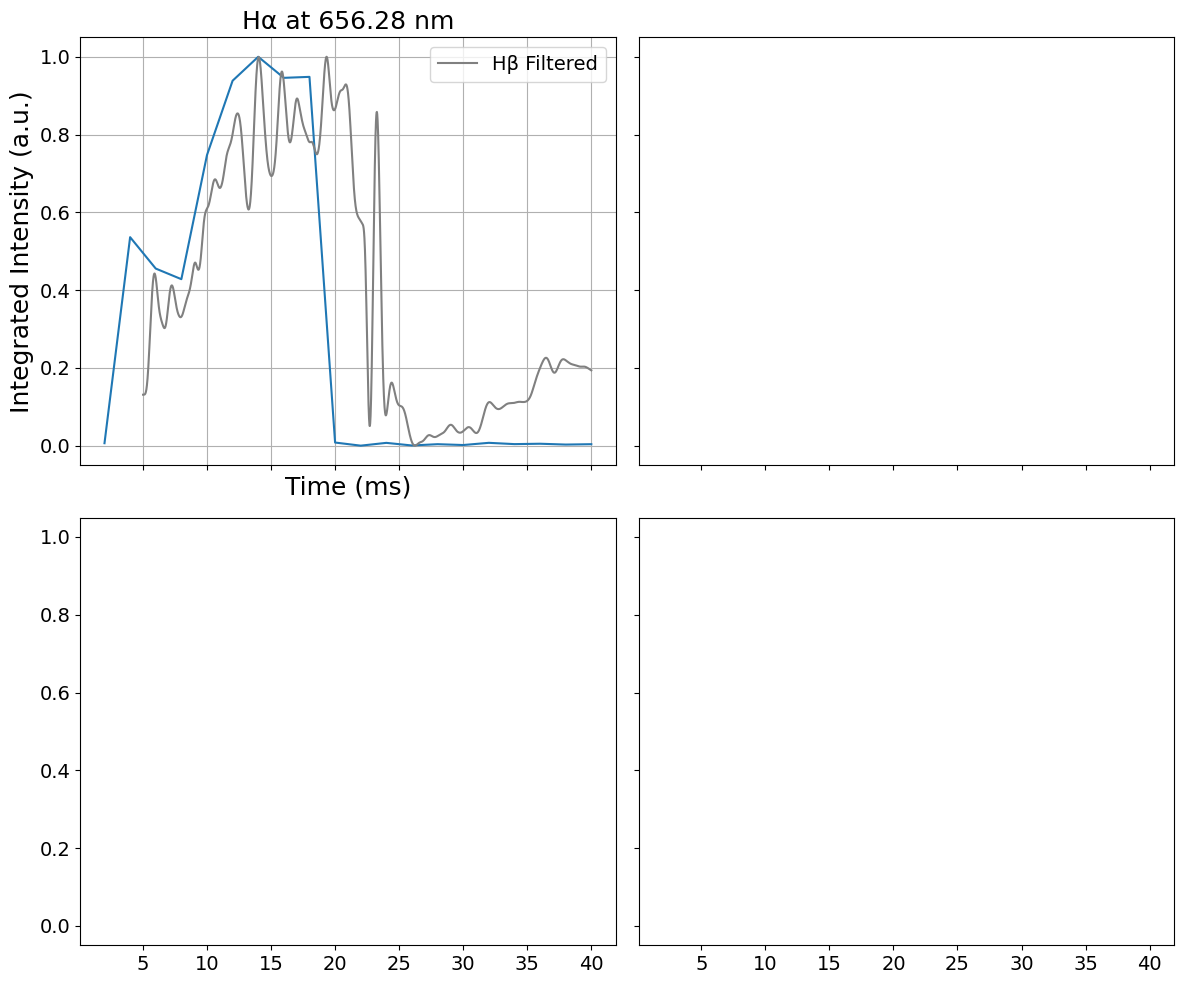

In [49]:
peaks = [
  {
    "name": "Hα",
    "wavelength": 656.28,
    "fwhm": 10,
    "fs_data": data['Hβ']
  }
]

compare_spectrometer(peaks, Wavelengths, Spectra)

In [ ]:
# Test new loader methods
print("Testing new diagnostic loaders...\n")

# Test basic diagnostics
print("1. Basic Diagnostics:")
basic = loader.load_basic_diagnostics()
print(f"   Toroidal field (Bt): {'✓' if basic.toroidal_field else '✗'}")
print(f"   Plasma current (Ip): {'✓' if basic.plasma_current else '✗'}")
print(f"   Chamber current (Ich): {'✓' if basic.chamber_current else '✗'}")
print(f"   Loop voltage: {'✓' if basic.loop_voltage else '✗'}")

# Test Mirnov coils
print("\n2. Mirnov Coils:")
mirnov = loader.load_mirnov_coils()
print(f"   Loaded {len(mirnov.coils)} coils: {sorted(mirnov.coils.keys())}")

# Test MHD ring
print("\n3. MHD Ring:")
mhd = loader.load_mhd_ring()
print(f"   Loaded {len(mhd.rings)} rings: {sorted(mhd.rings.keys())}")

# Test plasma detection
print("\n4. Plasma Detection:")
plasma = loader.load_plasma_detection()
signals = ['bt_coil', 'int_bt_coil', 'rog_coil', 'int_rog_coil', 'leyb_phot', 'loop']
available = [s for s in signals if getattr(plasma, s) is not None]
print(f"   {len(available)}/{len(signals)} signals available: {available}")

# Test shot info
print("\n5. Shot Info:")
info = loader.load_shot_info()
print(f"   Shot #{info.shot_number}")
print(f"   Logbook: {len(info.logbook) if info.logbook else 0} characters")
avail_count = sum(1 for v in info.available_diagnostics.values() if v)
print(f"   Available diagnostics: {avail_count}/{len(info.available_diagnostics)}")

print("\nAll new loaders working! ✓")